In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from scipy import signal
from apis.imaging_classes import save_disp_imgs,bootstrap_disp
from modules.utils import extract_ridge_ref_idx,plot_disp_curves
import random
import scipy
from tqdm.notebook import tqdm

# Load saved surface wave windows associated with vehicle states and speeds

In [2]:
# Define the file name using an f-string to include the value of _x0: pivot.
_x0 = 650
tracking_offset = 150
_start_x = _x0 - tracking_offset
_end_x = _x0 + tracking_offset
file_name = f"data/sw_data/{_x0}.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as f:
    # Load the pickled data from the file.
    windows_all = pickle.load(f)  # Load the 'windows_all' surface wave window data from the file.
    das_veh_states = pickle.load(f)  # Load the 'das_veh_states' data from the file.
    veh_speed = pickle.load(f)  # Load the 'veh_speed' data from the file.

# Get surface wave windows with different vehicle weights

## Use majority vehicle weights

In [3]:
# Calculate the mean along the first axis
das_veh_states_mean = []
for das_veh in das_veh_states:
    mean_tmp = signal.detrend(signal.savgol_filter(das_veh.mean(0),101,3))
    mean_tmp = mean_tmp-mean_tmp[0]
    das_veh_states_mean.append(mean_tmp)
# Calculate the peaks of the mean values.
peaks = np.max(np.abs(das_veh_states_mean), 1)

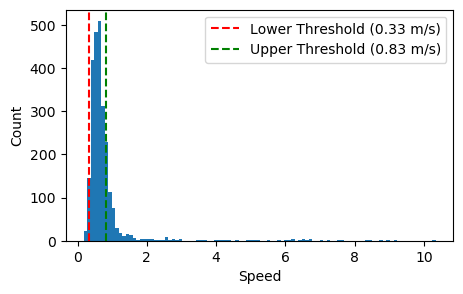

In [4]:
# Create a histogram of vehicle speeds.
fig = plt.figure(figsize=(5, 3))
plt.hist(peaks, bins=100)
plt.xlabel('Speed')
plt.ylabel('Count')
# Create a histogram of vehicle speeds.
hist, bins = np.histogram(peaks, bins=100)
# Find the bin with the highest frequency (the mode).
mode_peak = bins[np.argmax(hist)]
# Calculate the standard deviation of the vehicle speeds.
sigma = np.std(peaks)
# Define threshold values based on one sigma away from the mode.
lower_limit = mode_peak - 0.3*sigma
upper_limit = mode_peak + 0.3*sigma
# Define a condition to select speeds within one sigma of the mode.
peak_idx = np.where((peaks >= lower_limit) & (peaks <= upper_limit))[0]

# Plot vertical lines to mark the threshold values.
plt.axvline(lower_limit, color='r', linestyle='--', label=f'Lower Threshold ({lower_limit:.2f} m/s)')
plt.axvline(upper_limit, color='g', linestyle='--', label=f'Upper Threshold ({upper_limit:.2f} m/s)')
# Create a legend to label the threshold lines.
plt.legend()

# Filter das_veh_states_mean and windows_all_rm to only include elements with matching indices in speed_idx.
veh_speed = np.array([i for j, i in enumerate(veh_speed) if j in peak_idx])
das_veh_states = [i for j, i in enumerate(das_veh_states) if j in peak_idx]
windows_all = [i for j, i in enumerate(windows_all) if j in peak_idx]

## Spliting small, mid, and large speed vehicles

Number of Fast vehiles: 308
Number of Mid vehiles: 1353
Number of Slow vehiles: 296


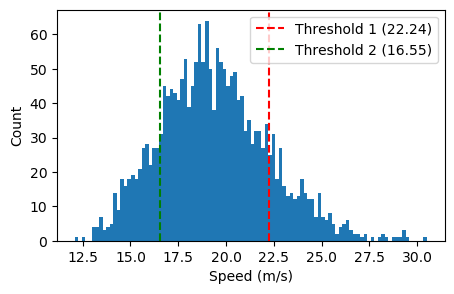

In [5]:
# Create a histogram of the speed.
fig = plt.figure(figsize=(5, 3))
n, bins, patches = plt.hist(veh_speed, bins=100)
plt.xlabel('Speed (m/s)')
plt.ylabel('Count')

# Define threshold values based on one sigma away from the mean.
threshold_1 = np.mean(veh_speed) + np.std(veh_speed)
threshold_2 = np.mean(veh_speed) - np.std(veh_speed)
# Plot vertical lines to mark the thresholds.
plt.axvline(threshold_1, color='r', linestyle='--', label=f'Threshold 1 ({threshold_1:.2f})')
plt.axvline(threshold_2, color='g', linestyle='--', label=f'Threshold 2 ({threshold_2:.2f})')
# Create a legend to label the threshold lines.
plt.legend()

# Classify speed into fast, midspeed, and slow based on the conditions.
fast_idx = np.where(veh_speed > threshold_1)[0]
mid_idx = np.where((veh_speed <= threshold_1) & (veh_speed > threshold_2))[0]
slow_idx = np.where(veh_speed <= threshold_2)[0]

# Print the number of elements in each category.
print(f'Number of Fast vehiles: {len(fast_idx)}')
print(f'Number of Mid vehiles: {len(mid_idx)}')
print(f'Number of Slow vehiles: {len(slow_idx)}')

In [6]:
windows_fast = []  
windows_mid = []  
windows_slow = [] 

# Iterate through fast_idx, mid_idx, and slow_idx to collect corresponding surface wave windows.
for k in fast_idx:
    windows_fast.append(windows_all[k])
for k in mid_idx:
    windows_mid.append(windows_all[k])
for k in slow_idx:
    windows_slow.append(windows_all[k])

# Imaging for different weights

## Plot

figures/650/sg_fast_cars.png has saved...
saving figures/650/disp_fast_cars_no_norm.png...
saving figures/650/disp_fast_cars_no_enhance.png...
saving figures/650/disp_fast_cars.png...
figures/650/sg_midspeed_cars.png has saved...
saving figures/650/disp_midspeed_cars_no_norm.png...
saving figures/650/disp_midspeed_cars_no_enhance.png...
saving figures/650/disp_midspeed_cars.png...
figures/650/sg_slow_cars.png has saved...
saving figures/650/disp_slow_cars_no_norm.png...
saving figures/650/disp_slow_cars_no_enhance.png...
saving figures/650/disp_slow_cars.png...


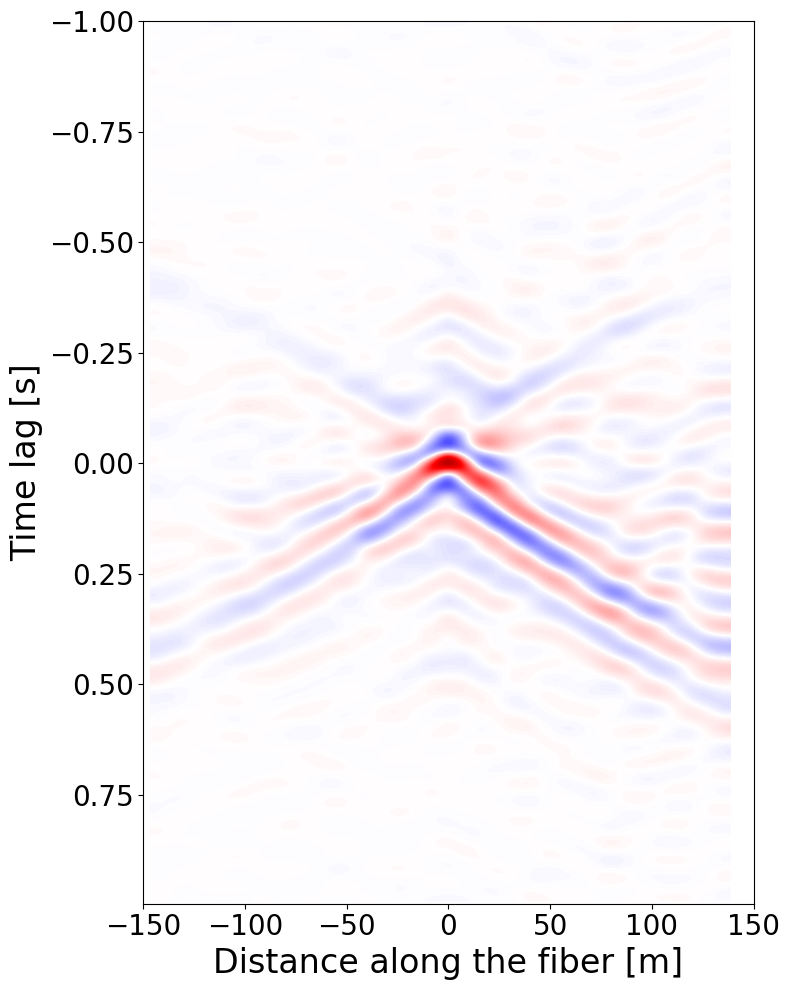

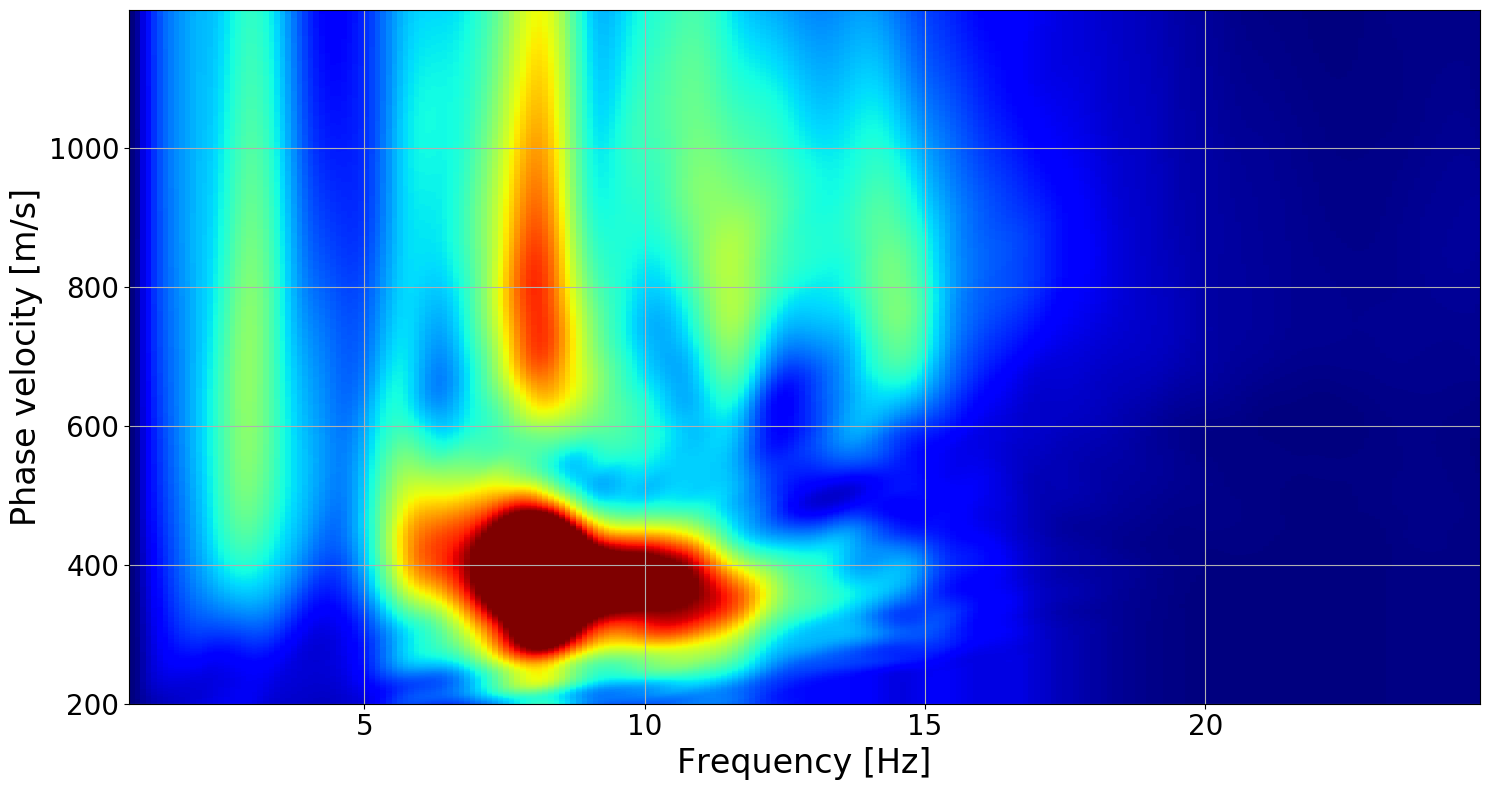

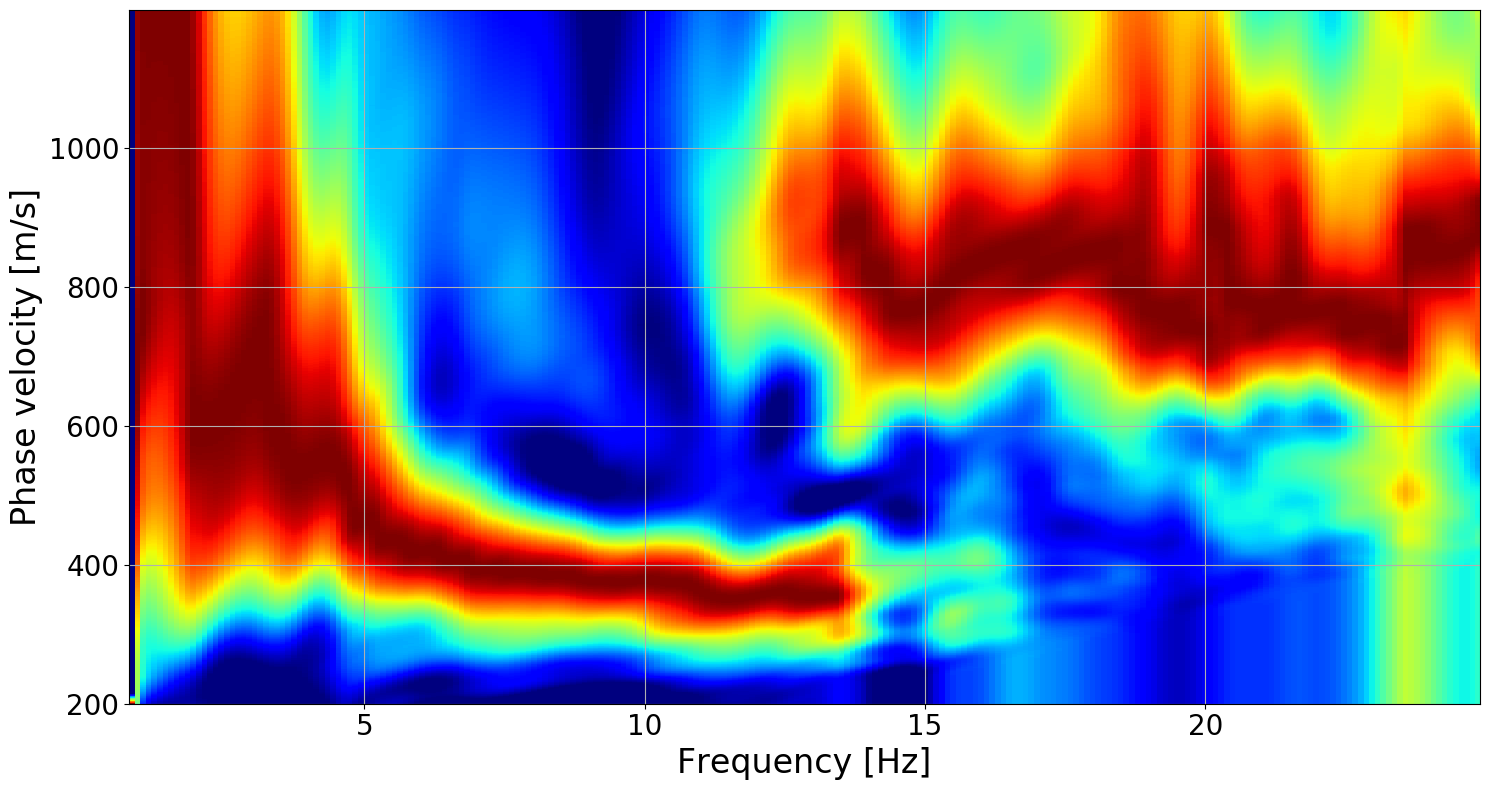

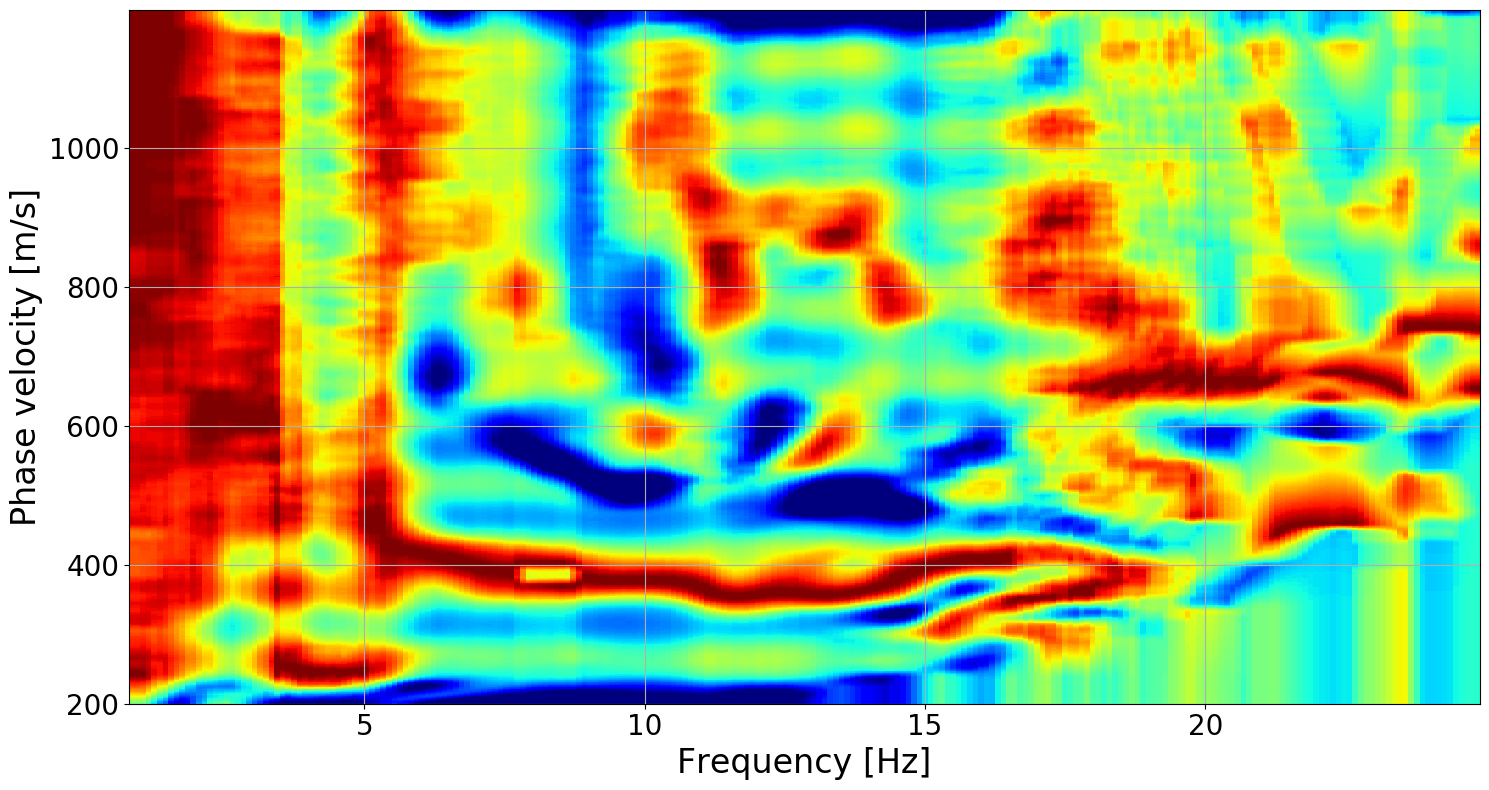

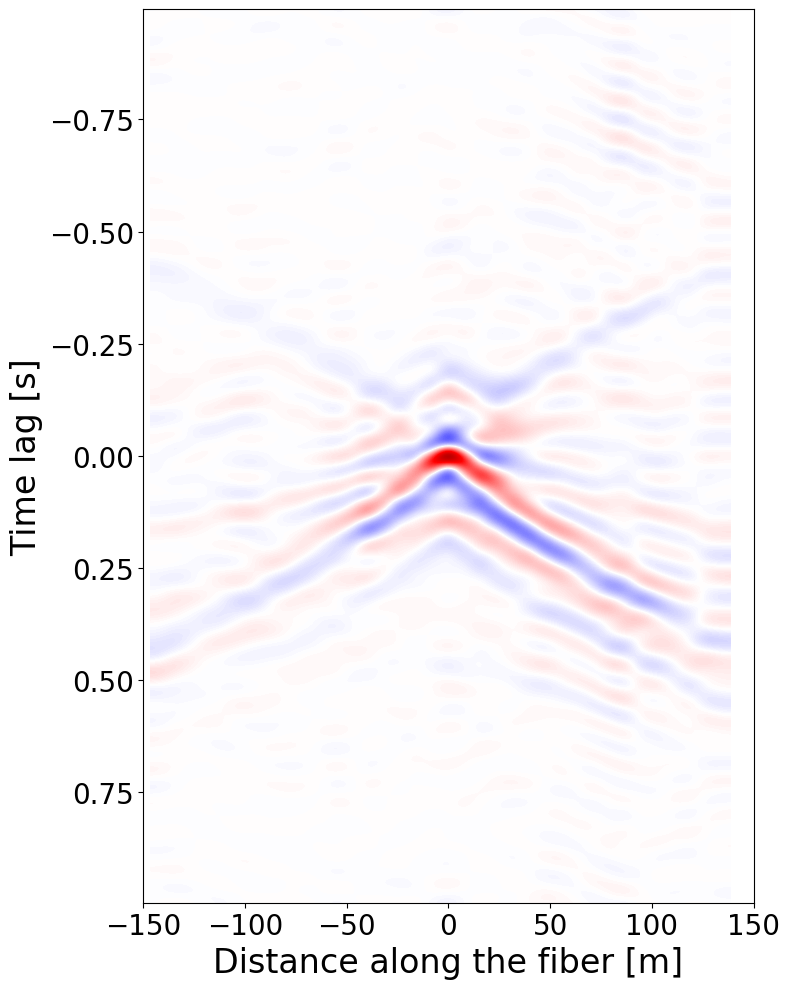

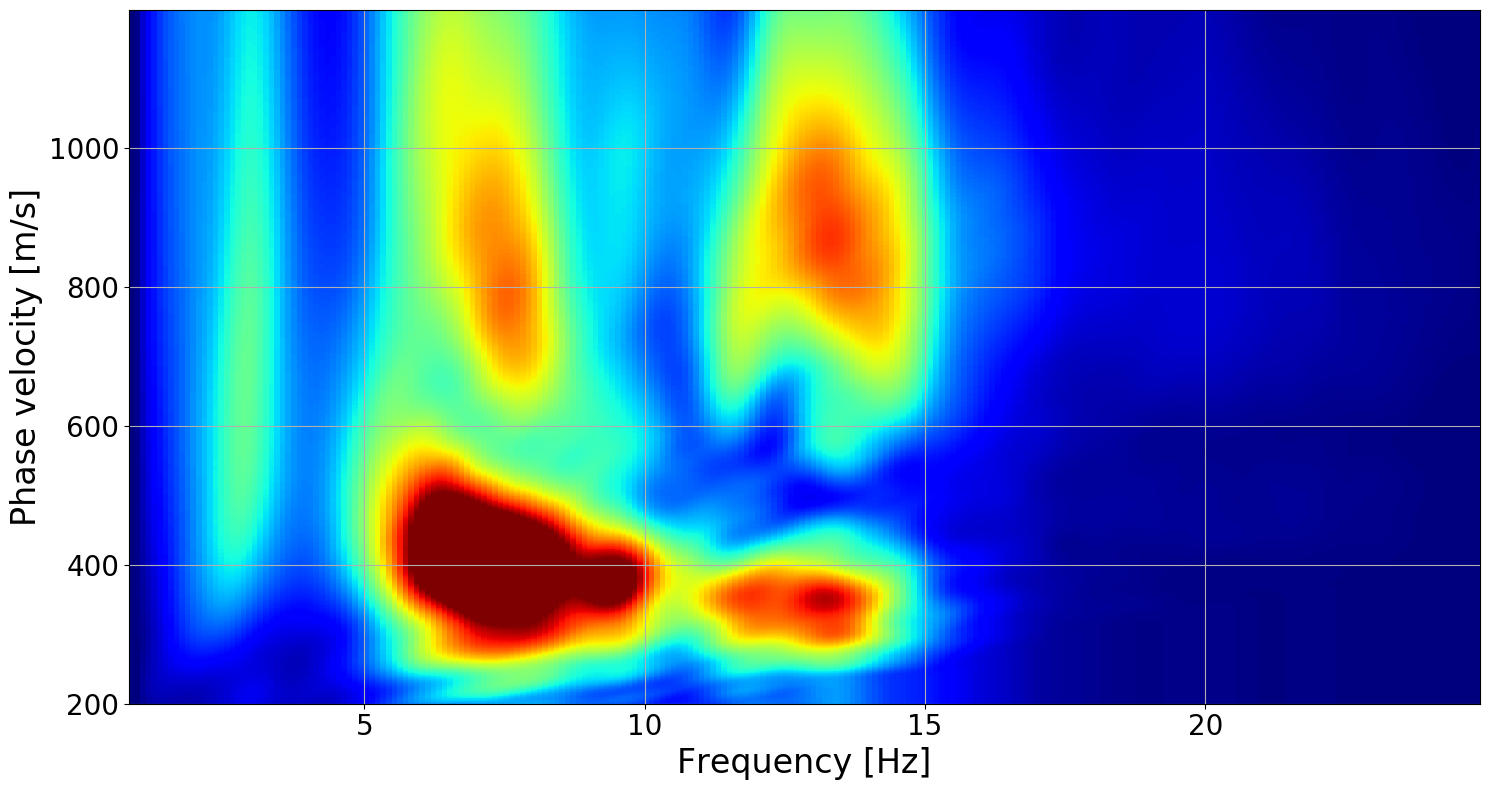

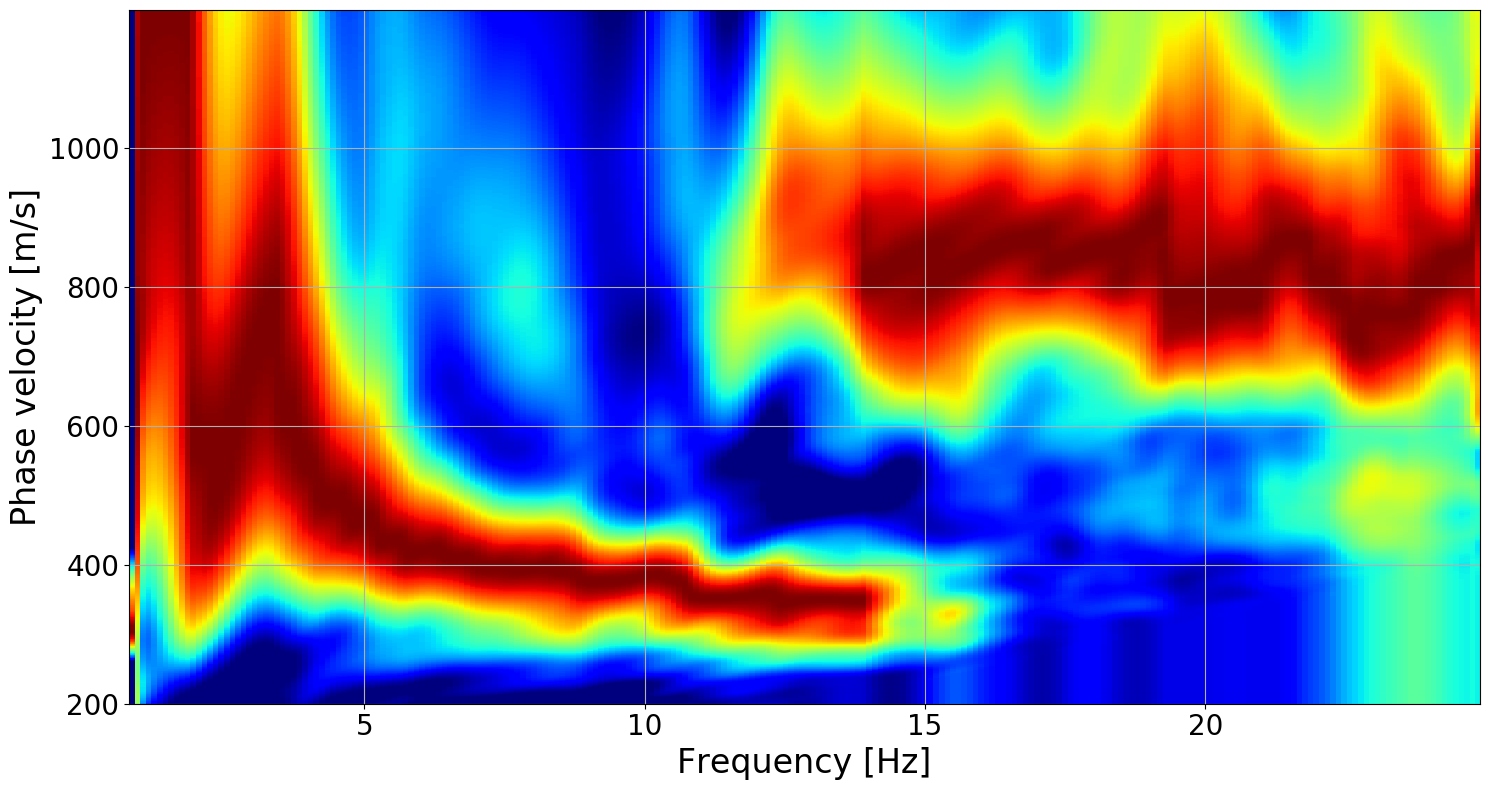

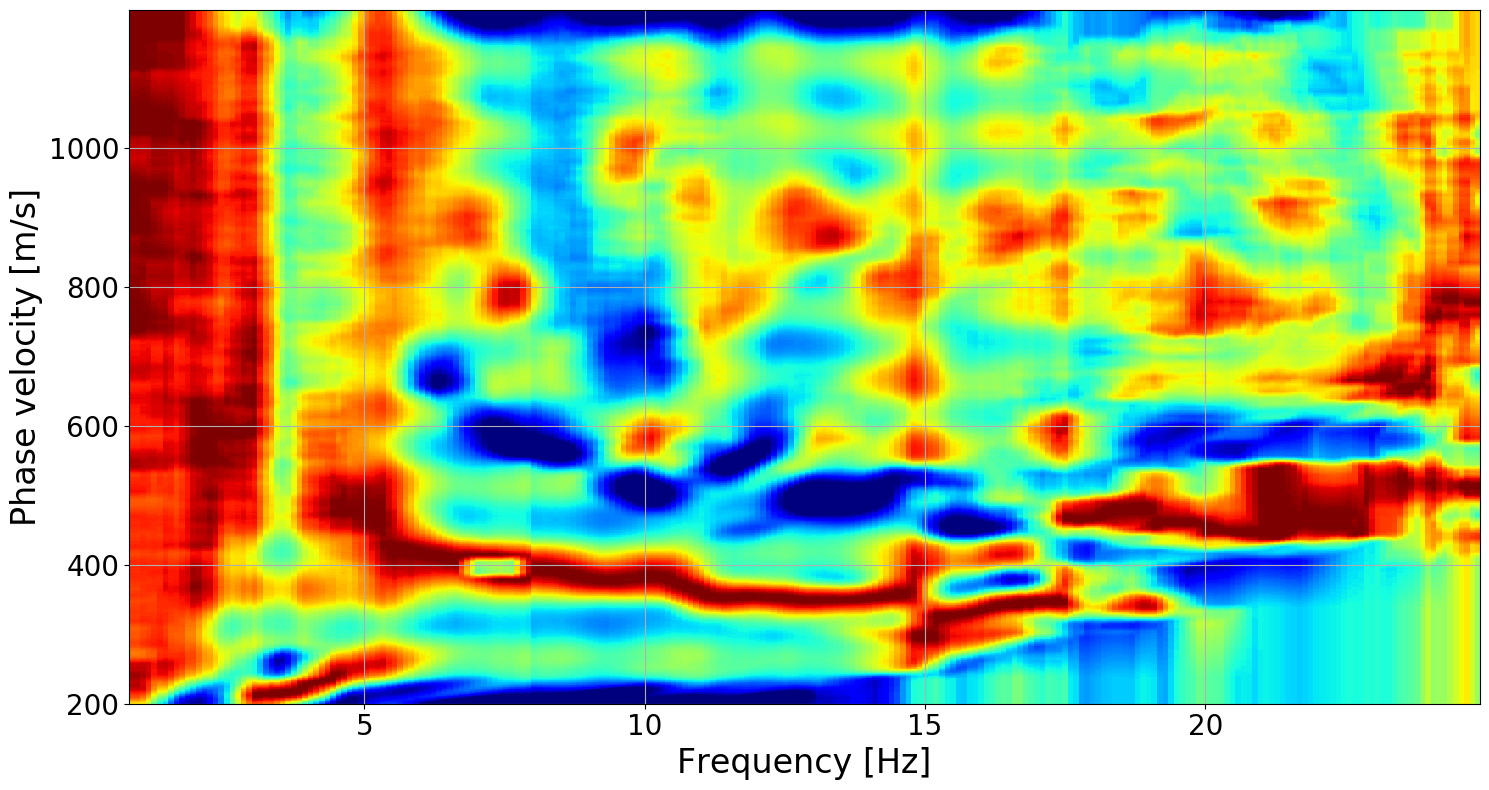

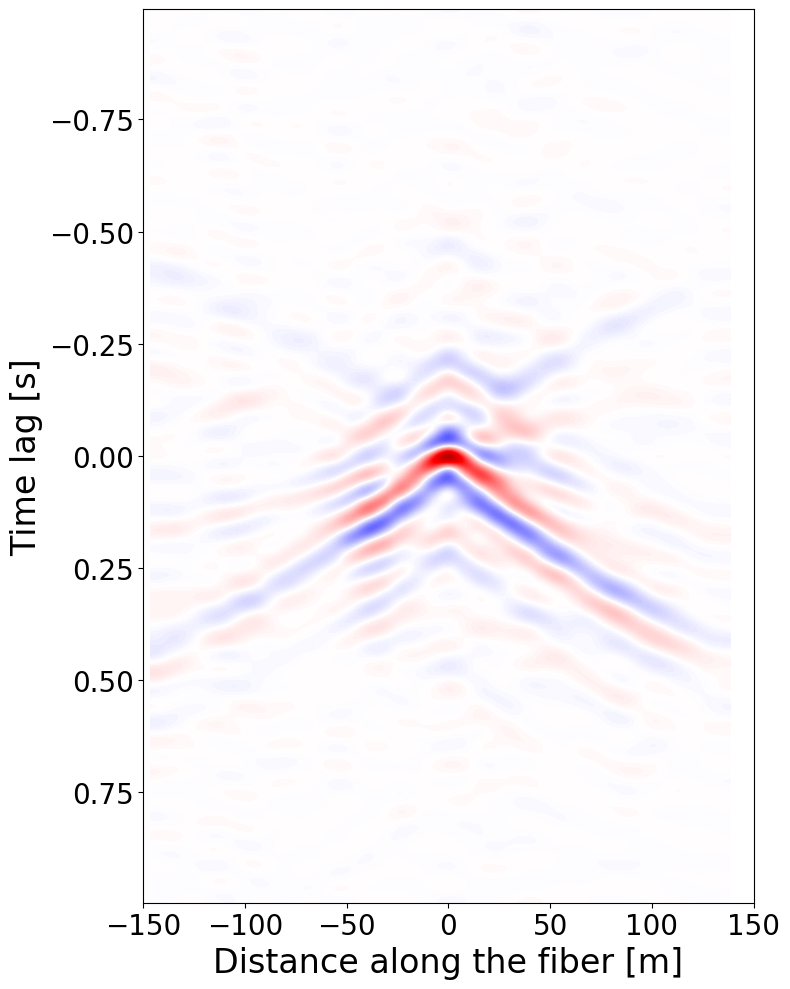

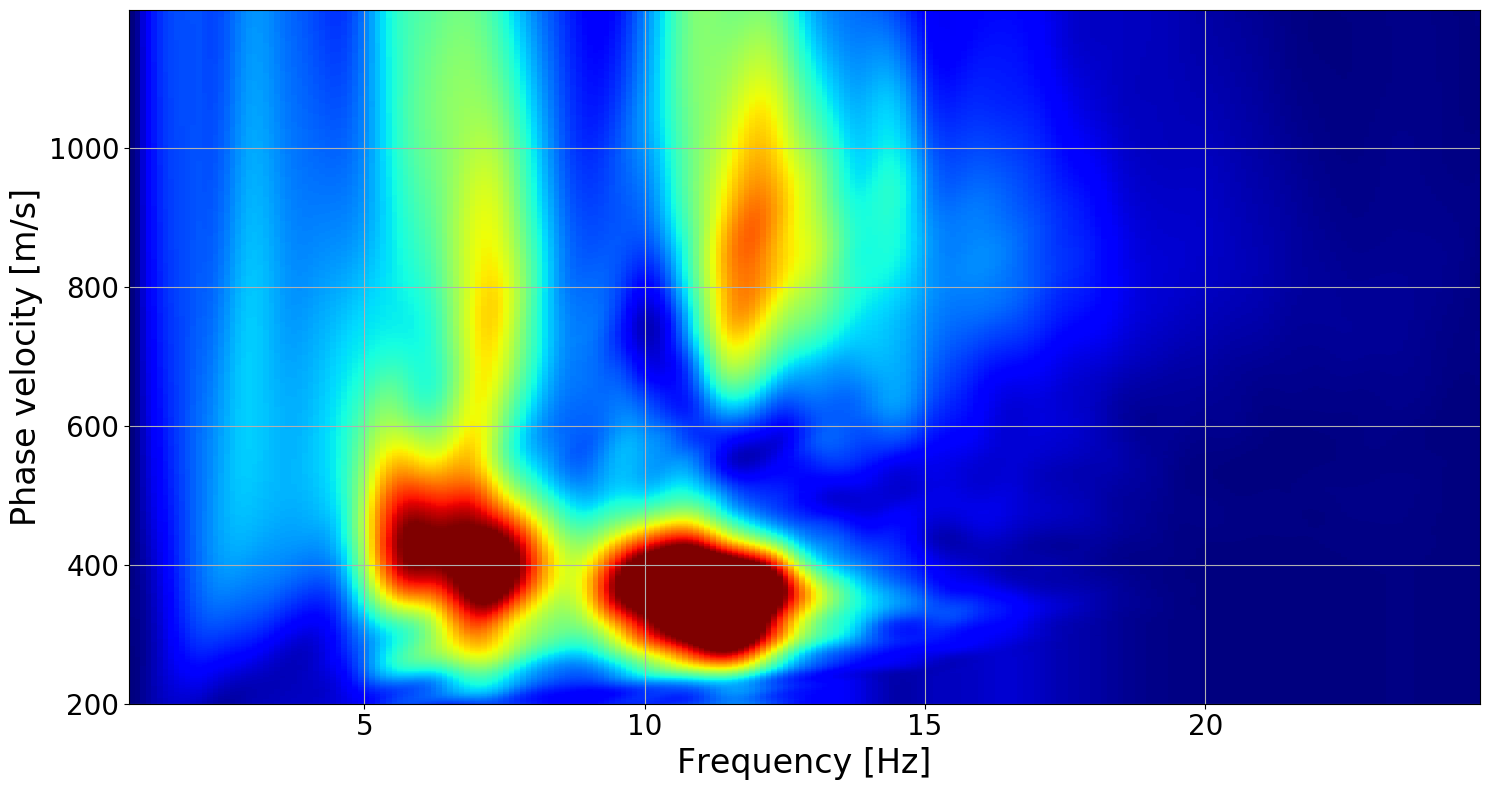

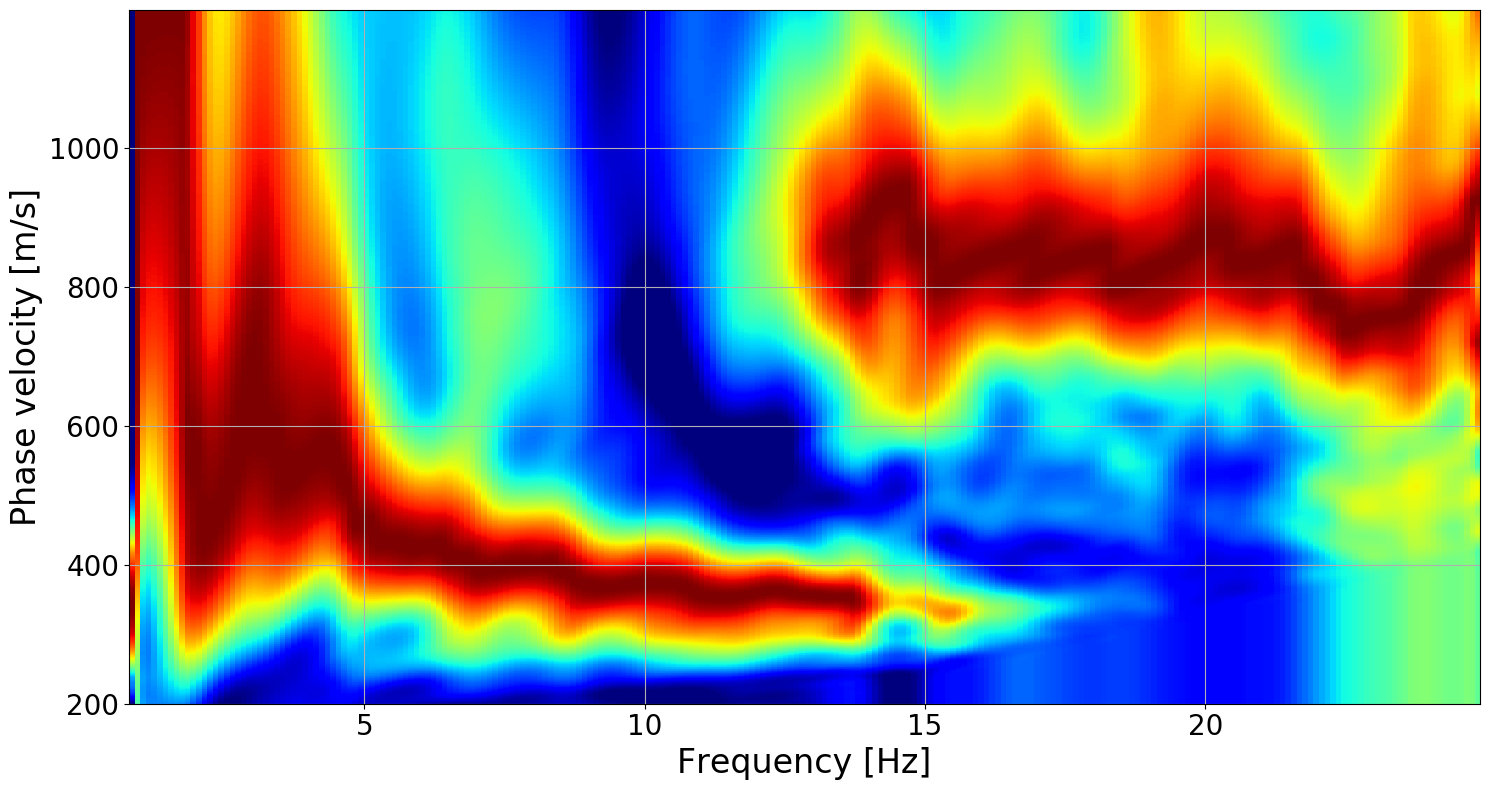

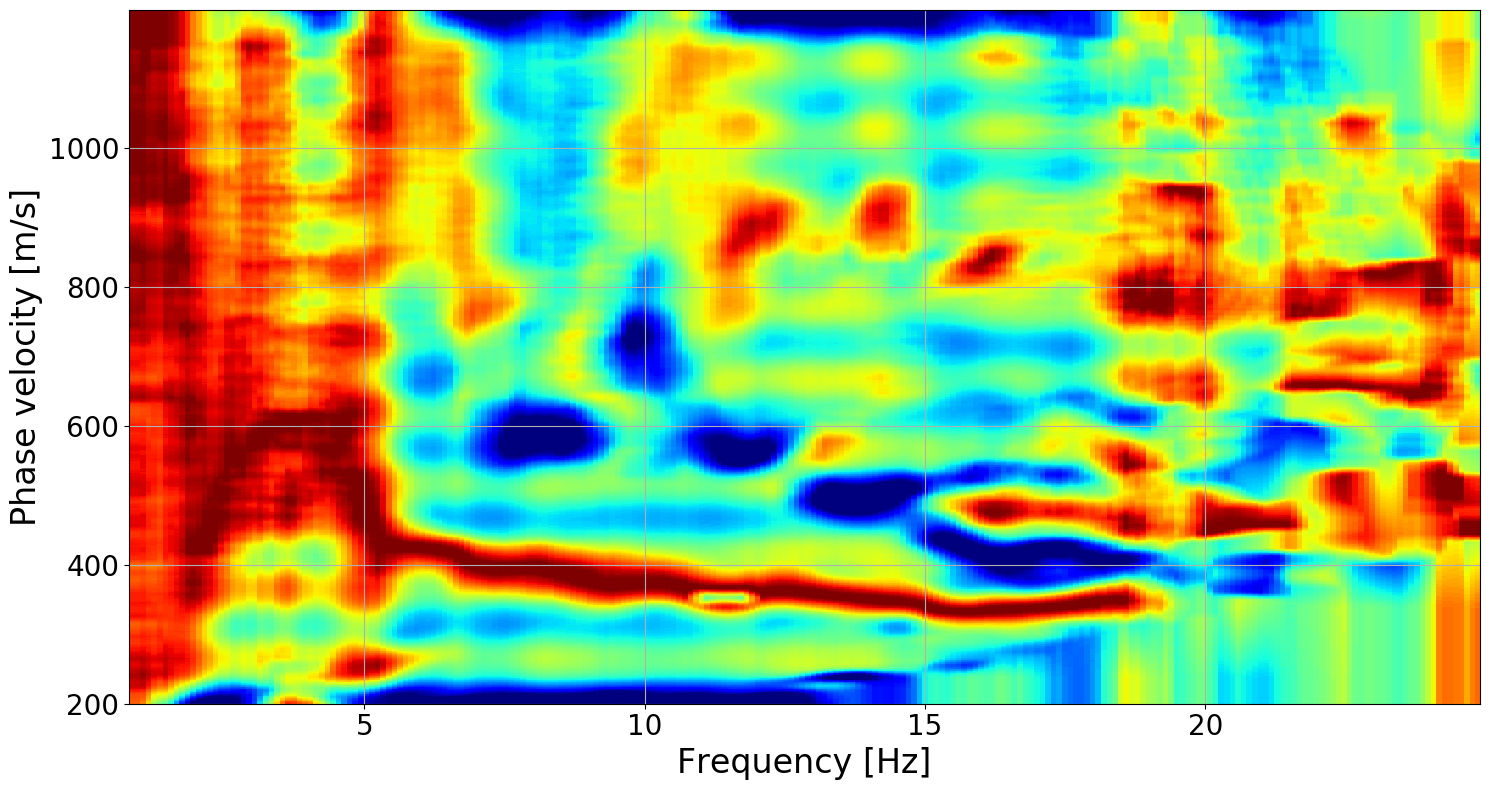

In [7]:
_min_win = np.min([len(windows_fast),len(mid_idx),len(windows_slow)])
images_fast = save_disp_imgs(windows_fast, 'fast', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')
images_mid = save_disp_imgs(windows_mid, 'midspeed', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')
images_slow = save_disp_imgs(windows_slow, 'slow', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

## Save image files

In [8]:
# file_name = f'data/saved_disp/{_x0}_images_speeds.pkl'
# with open(file_name, 'wb') as file:
#     pickle.dump(images_fast, file)
#     pickle.dump(images_mid, file)
#     pickle.dump(images_slow, file)
#     print(f'Object successfully saved to "{file_name}"')

## Bootstrapping


In [9]:
bt_times = 20
bt_size = 30
sigma = [25]
ref_freq_idx = [80]
freq_lb = [2.5]
freq_ub = [14]
vel_ref = [None]
ridge_vel_fast,freqs = bootstrap_disp(windows_fast,bt_size,bt_times,sigma,
                                       _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_mid,_ = bootstrap_disp(windows_mid,bt_size,bt_times,sigma,
                                       _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_slow,_ = bootstrap_disp(windows_slow,bt_size,bt_times,sigma,
                                       _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)

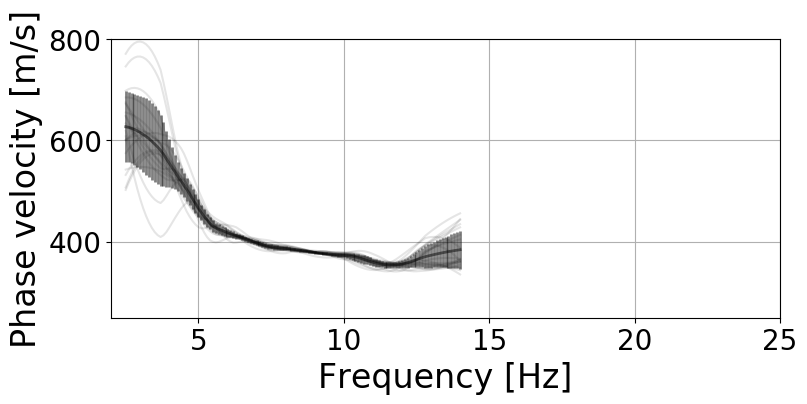

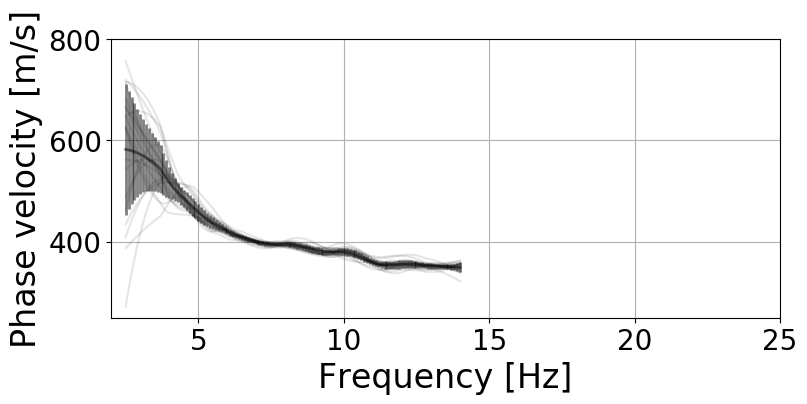

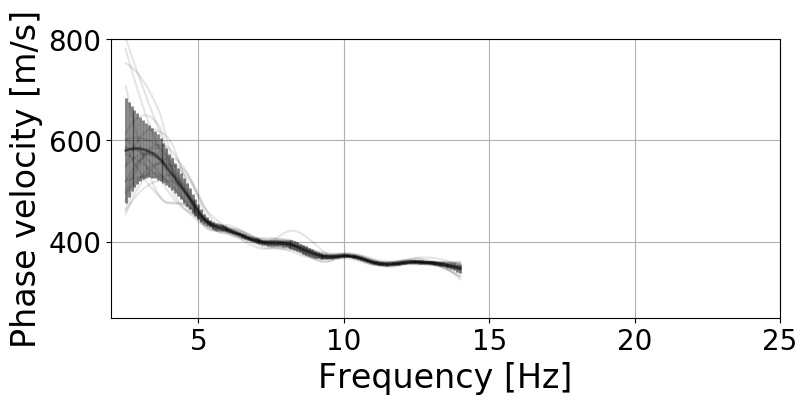

([array([ 580.08326496,  581.98110256,  583.26981717,  583.94940877,
          584.01987737,  583.48122297,  582.33344556,  580.57654515,
          578.21052174,  575.23537533,  571.65110591,  567.45771349,
          562.65519807,  555.28914976,  547.84610628,  540.57441546,
          533.2173913 ,  525.65515942,  517.95639614,  509.94108213,
          501.74843478,  493.36476329,  484.62509179,  475.88881159,
          467.24965217,  458.97352657,  451.31945894,  444.85651208,
          439.59176812,  435.47263768,  432.16868599,  429.70028019,
          428.07519807,  426.89711111,  425.48514976,  423.6170628 ,
          421.44682126,  419.2242029 ,  417.22529469,  415.04223188,
          412.55828986,  410.06462802,  407.75560386,  405.62143961,
          403.69905314,  401.94900483,  400.32744928,  398.99590338,
          397.96868599,  397.38904348,  397.26455072,  397.46890821,
          397.4529372 ,  397.26512077,  396.86605797,  396.39237681,
          395.68574879,  394.48128

In [10]:
plot_disp_curves(freqs,freq_lb,freq_ub, ridge_vel_fast)
plot_disp_curves(freqs,freq_lb,freq_ub, ridge_vel_mid)
plot_disp_curves(freqs,freq_lb,freq_ub, ridge_vel_slow)

## Convergence test


In [11]:
def convergence_test(max_sample_num,windows,bt_times,sigma,
                     x0,start_x,end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref):
    ridge_vel_std = np.empty((len(freq_lb),max_sample_num))
    for bt_size in tqdm(range(1,max_sample_num+1)):
        ridge_vel,freqs = bootstrap_disp(windows,bt_size,bt_times,sigma,x0,start_x,end_x,
                                         ref_freq_idx,freq_lb,freq_ub,vel_ref)
        for mode in range(len(freq_lb)):
            ridge_vel_std[mode,bt_size-1] = np.sum(np.std(ridge_vel[mode],axis=0))
    return ridge_vel_std


In [12]:
bt_sample_num = 50
ridge_vel_fast_std = convergence_test(bt_sample_num,windows_fast,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_mid_std = convergence_test(bt_sample_num,windows_mid,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_slow_std = convergence_test(bt_sample_num,windows_slow,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

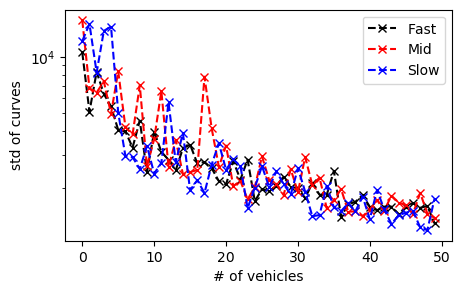

In [13]:
for mode in range(len(freq_lb)):
    plt.figure(figsize=(5,3))
    plt.semilogy(ridge_vel_fast_std[mode],'x--k',label='Fast')
    plt.semilogy(ridge_vel_mid_std[mode],'x--r',label='Mid')
    plt.semilogy(ridge_vel_slow_std[mode],'x--b',label='Slow')
    plt.xlabel('# of vehicles')
    plt.ylabel('std of curves')
#     plt.ylim([])
    plt.legend()
    plt.savefig(f'figures/{_x0}/mode{mode+1}_sizes.png')